In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import networkx as nx
import pandas as pd

from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

TIME_STEPS = 120
MEMORY_LENGTH = 132
GROUPS = {
    "institutions": {"count": 5, "assets_range": (1000000, 2000000), "ball_range": (1000, 2000)}, #58
    "general_public": {"count": 9, "assets_range": (5000, 20000), "ball_range": (100, 500)}, #99
    "inside_investors": {"count": 1, "assets_range": (20000, 100000), "ball_range": (1500, 3000)}
}

price_events = {
    6: -0.0588,
    12: 0.004,
    25: -0.063,
    39: -0.039,
    52: -0.011,
    65: 0.0018,
    78: 0.0044,
    91: 0.015,
}

# GLOBAL BUDGET for curing each step 
CURE_BUDGET = 1000

G = nx.Graph()


In [2]:
def initialize_investors():
    for group, data in GROUPS.items():
        for i in range(data["count"]):
            node = f"{group}_{i}"
            initial_assets = np.random.randint(*data["assets_range"])
            # fraction of red/black in the given range
            max_balls = data["ball_range"][1]
            initial_red_balls = int(np.random.uniform(0.1, 0.2) * max_balls)
            initial_black_balls = max_balls - initial_red_balls

            G.add_node(node,
                       assets=initial_assets,
                       red_balls=initial_red_balls,
                       black_balls=initial_black_balls,
                       group=group,
                       memory=[])

    # Define specific connections 
    for i in range(GROUPS["institutions"]["count"]):
        institution_node = f"institutions_{i}"
        G.add_edge(institution_node, "inside_investors_0")
        for j in range(GROUPS["general_public"]["count"]):
            G.add_edge(institution_node, f"general_public_{j}")

In [3]:
def create_super_urn(node):
    """Sum red/black from the node + its neighbors."""
    red_total = G.nodes[node]['red_balls']
    black_total = G.nodes[node]['black_balls']
    for neighbor in G.neighbors(node):
        red_total += G.nodes[neighbor]['red_balls']
        black_total += G.nodes[neighbor]['black_balls']
    return red_total, black_total

In [4]:
def apply_cure(strategy="uniform"):
    """
    Distribute 'cure' across nodes to reduce red_balls,
    subject to a total CURE_BUDGET each time step.

    strategy can be one of:
    1) 'uniform'      - Everyone gets the same share of cure
    2) 'targeted'     - Nodes with the highest negativity fraction get more
    3) 'supermartingale' - A minimal approach ensuring node-level negativity doesn't drift up
    """

    # Gather negativity fractions to allocate budget
    negativity_list = []
    for node in G.nodes:
        rb = G.nodes[node]["red_balls"]
        bb = G.nodes[node]["black_balls"]
        total = rb + bb if (rb+bb>0) else 1
        negativity_list.append((node, rb/total))

    N = len(negativity_list)
    if N == 0:
        return

    if strategy == "uniform":
        # Just divide budget equally among all nodes
        cure_per_node = int(CURE_BUDGET / N)
        for (node, negfrac) in negativity_list:
            # 'Removing' cure_per_node red balls if possible
            G.nodes[node]["red_balls"] = max(0, G.nodes[node]["red_balls"] - cure_per_node)

    elif strategy == "blanket":
        # Sort nodes by negativity fraction desc
        negativity_list.sort(key=lambda x: x[1], reverse=True)

        # could do a simple approach: give more cure to top 20% worst nodes
        top_k = int(0.2*N) if int(0.2*N)>0 else 1
        cure_top = int(0.8 * CURE_BUDGET)  # 80% of budget for top 20%
        cure_rest = CURE_BUDGET - cure_top

        # top 20% share
        cure_each_top = int(cure_top / top_k)
        # rest share
        cure_each_other = int(cure_rest / (N - top_k)) if (N - top_k)>0 else 0

        for i, (node, negfrac) in enumerate(negativity_list):
            if i < top_k:
                G.nodes[node]["red_balls"] = max(0, G.nodes[node]["red_balls"] - cure_each_top)
            else:
                G.nodes[node]["red_balls"] = max(0, G.nodes[node]["red_balls"] - cure_each_other)

    elif strategy == "supermartingale":
        # If a node's negativity fraction is above some threshold, 
        # forcibly reduce red balls so that it's below that threshold.
        # a simplification of supermartingale logic.
        threshold = 0.18  
        total_cure_used = 0

        negativity_list.sort(key=lambda x: x[1])

        for node, negfrac in negativity_list:
            if total_cure_used >= CURE_BUDGET:
                break
            if negfrac > threshold:
                # how many red balls to remove so that negfrac <= threshold
                rb = G.nodes[node]["red_balls"]
                bb = G.nodes[node]["black_balls"]
                needed = int(rb - threshold*(rb+bb))
                if needed > 0:
                    if total_cure_used + needed <= CURE_BUDGET:
                        # can cure fully
                        G.nodes[node]["red_balls"] = rb - needed
                        total_cure_used += needed
                    else:
                        # partial cure
                        leftover = CURE_BUDGET - total_cure_used
                        G.nodes[node]["red_balls"] = max(0, rb - leftover)
                        total_cure_used += leftover

In [5]:
def polya_step(t, cure_strategy=None):
    """
    Perform one step of the Polya contagion process,
    optionally applying a cure strategy.
    """

    # 1) Apply a cure strategy at the start of the time step 
    if cure_strategy is not None:
        apply_cure(cure_strategy)

    # 2) Standard Polya draws & price impact
    for node in G.nodes:
        red, black = create_super_urn(node)
        total_balls = red + black
        if total_balls > 0:
            if np.random.rand() < red / total_balls:
                G.nodes[node]["red_balls"] += 10
                G.nodes[node]["assets"] *= (1 - 0.01)
            else:
                G.nodes[node]["black_balls"] += 10
                G.nodes[node]["assets"] *= (1 + 0.01)

        # Price impact events
        if t in price_events:
            # Additional red balls to simulate negative market reaction
            if price_events[t] < 0:
                red_increase = int(G.nodes[node]["red_balls"] * abs(price_events[t]))
                G.nodes[node]["red_balls"] += red_increase
            # Adjust assets
            G.nodes[node]["assets"] *= (1 + price_events[t])

        # Memory
        G.nodes[node]["memory"].append({
            "red_balls": G.nodes[node]["red_balls"],
            "black_balls": G.nodes[node]["black_balls"]
        })
        if len(G.nodes[node]["memory"]) > MEMORY_LENGTH:
            G.nodes[node]["memory"].pop(0)

In [6]:
average_sentiment_history = {"institutions": [], "general_public": [], "inside_investors": []}
susceptibility_history = []
infection_rate_history = []
exposure_history = []

In [7]:
def calculate_network_susceptibility():
    values = []
    for node in G.nodes:
        rb = G.nodes[node]["red_balls"]
        bb = G.nodes[node]["black_balls"]
        total = rb + bb
        if total>0:
            values.append(rb/total)
    return np.mean(values) if values else 0

def create_super_urn(node):
    red_total = G.nodes[node]['red_balls']
    black_total = G.nodes[node]['black_balls']
    for neighbor in G.neighbors(node):
        red_total += G.nodes[neighbor]['red_balls']
        black_total += G.nodes[neighbor]['black_balls']
    return red_total, black_total

def calculate_infection_rate():
    arr = []
    for node in G.nodes:
        super_red, super_black = create_super_urn(node)
        total = super_red + super_black
        if total>0:
            arr.append(super_red/total)
    return np.mean(arr) if arr else 0

def calculate_network_exposure():
    arr = []
    for node in G.nodes:
        sr, sb = create_super_urn(node)
        total = sr + sb
        if total>0:
            arr.append(sr/total)
    return np.mean(arr) if arr else 0

In [8]:
def run_simulation_with_cure(cure_strategy=None):
    # re-init
    for group in average_sentiment_history:
        average_sentiment_history[group].clear()
    susceptibility_history.clear()
    infection_rate_history.clear()
    exposure_history.clear()

    # MAIN LOOP
    for t in range(TIME_STEPS):
        polya_step(t, cure_strategy=cure_strategy)

        # Log group sentiments
        for group in GROUPS.keys():
            group_nodes = [n for n in G.nodes if G.nodes[n]["group"] == group]
            if group_nodes:
                group_sent = []
                for node in group_nodes:
                    rb = G.nodes[node]["red_balls"]
                    bb = G.nodes[node]["black_balls"]
                    tot = rb+bb
                    if tot>0:
                        group_sent.append(bb/tot)
                avg_sent = np.mean(group_sent) if group_sent else 0
                average_sentiment_history[group].append(avg_sent)

        # Log overall metrics
        susceptibility_history.append(calculate_network_susceptibility())
        infection_rate_history.append(calculate_infection_rate())
        exposure_history.append(calculate_network_exposure())

In [9]:
def plot_sentiment_by_group():
    plt.figure(figsize=(12, 5))
    for group, vals in average_sentiment_history.items():
        plt.plot(vals, label=group)
    plt.xlabel("Time Step")
    plt.ylabel("Average Sentiment (black / total)")
    plt.title("Group Sentiment Over Time")
    plt.legend()
    plt.show()

def plot_metrics():
    fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

    ax[0].plot(susceptibility_history, color='blue')
    ax[0].set_ylabel("Susceptibility (U(t))")
    ax[0].set_title("Network Susceptibility Over Time")

    ax[1].plot(infection_rate_history, color='red')
    ax[1].set_ylabel("Infection Rate (I(t))")
    ax[1].set_title("Infection Rate Over Time")

    ax[2].plot(exposure_history, color='green')
    ax[2].set_ylabel("Exposure (S(t))")
    ax[2].set_title("Network Exposure Over Time")
    ax[2].set_xlabel("Time Step")

    plt.tight_layout()
    plt.show()

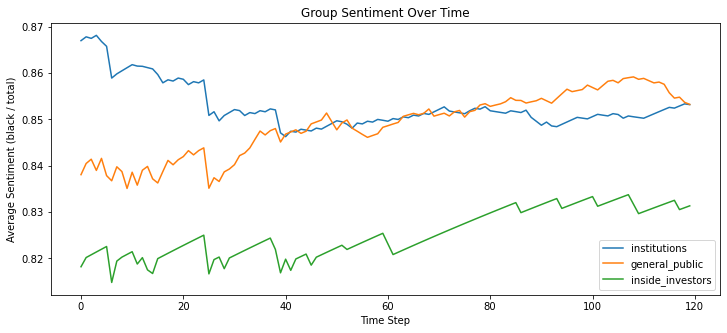

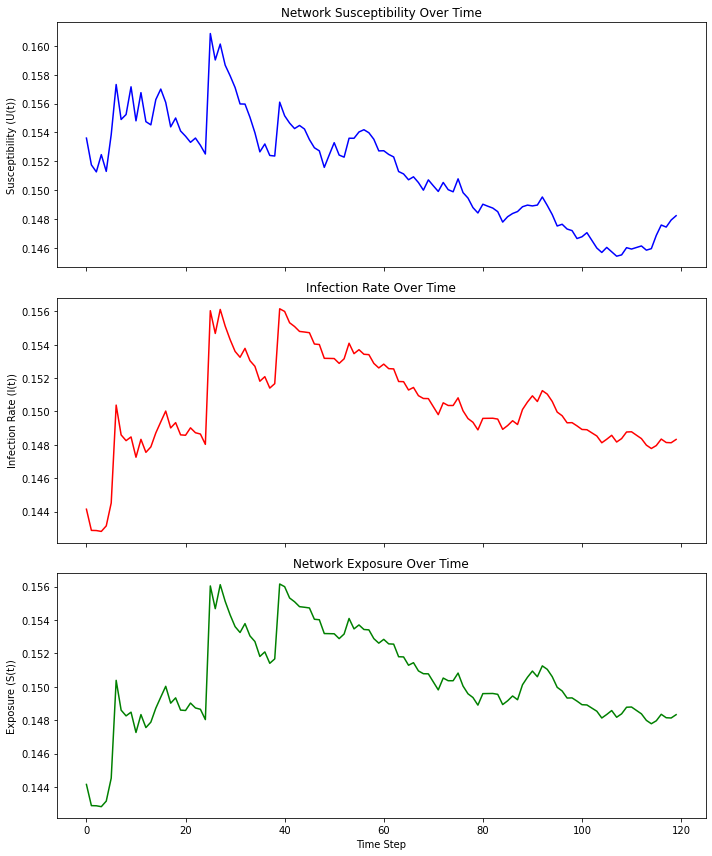

In [10]:
G.clear()
initialize_investors()

run_simulation_with_cure(cure_strategy="supermartingale")

plot_sentiment_by_group()
plot_metrics()


## 2025/01/30 NOTES: change susceptibility to a weighted function between 0 and 1 with the sum of these weights equal to 1; 
# these weights can
## represent the economic impact of the node (WRITE DOWN MATHEMATICAL EQUATIONS AND DEFINE ECONOMIC IMPACT)

In [11]:
def init_3d_layout():
    for node in G.nodes:
        G.nodes[node]['pos_3d'] = np.random.rand(3)*10

def animate_simulation_3d(cure_strategy=None):

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Convert node positions to array
    pos_dict = {node: G.nodes[node]['pos_3d'] for node in G.nodes}

    def update(frame):
        ax.clear()
        # Do a polya step with cure
        polya_step(frame, cure_strategy=cure_strategy)

        # gather coordinates & color
        xs, ys, zs, colors, sizes = [], [], [], [], []
        for node in G.nodes:
            x, y, z = pos_dict[node]
            xs.append(x)
            ys.append(y)
            zs.append(z)
            rb = G.nodes[node]['red_balls']
            bb = G.nodes[node]['black_balls']
            frac = 0.5  # default
            if (rb+bb) > 0:
                frac = bb/(rb+bb)  # fraction of "black" sentiment
            # color scale from red (0) to blue (1).
            colors.append(c)
            # scale node size
            sizes.append(G.nodes[node]['assets']/3000)  

        ax.scatter(xs, ys, zs, c=colors, s=sizes, alpha=0.6)
        ax.set_title(f"3D Polya Animation (Frame {frame})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.set_zlim(0, 10)

    ani = animation.FuncAnimation(fig, update, frames=TIME_STEPS, interval=500, blit=False)
    return HTML(ani.to_jshtml())

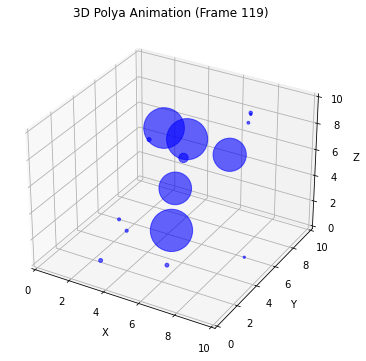

In [12]:
G.clear()
initialize_investors()
init_3d_layout()

html_anim = animate_simulation_3d(cure_strategy="uniform")
html_anim